In [1]:
import os
import tempfile
import pywcs
import shutil
import sys
import glob
import h5py
import pyfits
from pylab import arange, show, cm
import scipy.optimize as opt

import pandas as pd
import numpy as np
import healpy as hp

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle, FK5
import time
# from reproject import reproject_from_healpix


import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Third-party imports
import gcn
import gcn.handlers
import gcn.notice_types
import requests
import subprocess

%matplotlib inline

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def get_skymap(root):
    """
    Look up URL of sky map in VOEvent XML document,
    download sky map, and parse FITS file.
    """
    # Read out URL of sky map.
    # This will be something like
    # https://gracedb.ligo.org/apibasic/events/M131141/files/bayestar.fits.gz
    skymap_url = root.find(
        "./What/Param[@name='SKYMAP_URL_FITS_BASIC']").attrib['value']

    # Send HTTP request for sky map
    response = requests.get(skymap_url, stream=True)

    # Uncomment to save VOEvent payload to file
    # open('example.xml', 'w').write(payload)

    # Raise an exception unless the download succeeded (HTTP 200 OK)
    response.raise_for_status()

    # Create a temporary file to store the downloaded FITS file
    with tempfile.NamedTemporaryFile() as tmpfile:
        # Save the FITS file to the temporary file
        shutil.copyfileobj(response.raw, tmpfile)
        tmpfile.flush()

        # Uncomment to save FITS payload to file
        # shutil.copyfileobj(reponse.raw, open('example.fits.gz', 'wb'))

        # Read HEALPix data from the temporary file
        skymap, header = hp.read_map(tmpfile.name, h=True, verbose=False)
        header = dict(header)

    # Done!
    return skymap, header

def max_probability(skymap):
    npix = len(skymap)
    nside = hp.npix2nside(npix)
    ipix_max = np.argmax(skymap)
    skymap[ipix_max]
    theta, phi = hp.pix2ang(nside, ipix_max)
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    return ra, dec

def download_skymap(grace_id, name='bayestar', base_url='https://gracedb.ligo.org/apiweb/superevents'):
    """
    Download a sky map from GraceDb.

    Parameters
    ----------
    grace_id : string
        The GraceDb identifier of the event
    name : string
        The filename, less the '.fits.gz' extension
    base_url : string
        The base URL of the GraceDb server. By default, the production server.
    """

    command = 'curl --netrc {base_url}/{grace_id}/files/{name}.fits.gz -o {grace_id}_{name}.fits.gz'.format(
        base_url=base_url, grace_id=grace_id, name=name)
    print(command)
    os.system(command)


In [3]:
# grace_id = 'S190412m'        # identifier for the event
grace_id = 'S200213t' 
download_skymap(grace_id)

curl --netrc https://gracedb.ligo.org/apiweb/superevents/S200213t/files/bayestar.fits.gz -o S200213t_bayestar.fits.gz


In [5]:

filename13 = 'S200213t_bayestar.fits.gz'
_img13 = "/data/20200213/2020-02-13T04:10:40-S314-B8.fits"


filename12 = 'S190930t_bayestar.fits.gz'
_img12 = "/data/GW_20190930/NSBH/20190930143407UTC_S316.5_I8x1_W6_A1.5.fits"


filename11 = 'S190930s_bayestar.fits.gz'
_img11 = "/data/GW_20190930/20190930133541UTC_S316.5_I8x1_W6_A1.5.fits"


filename10 = 'S190901ap_bayestar.fits.gz'
_img10 = "/data/20190901/2019-09-01T23:31:01-S314-B8.fits"

filename9 = 'S190828l_bayestar.fits.gz'
_img9 = "/data/20190828/2019-08-28T06:34:05-S314-B8.fits"

filename8 = 'S190828j_bayestar.fits.gz'
_img8 = "/data/20190828/2019-08-28T06:55:09-S314-B8.fits"

filename7 = 'S190816i_bayestar.fits.gz'
# _img7 = "/data/20190816/2019-08-16T13:04:31-S314-B7.fits"
# # _img7 = "/data/20190518/2019-05-18T18:58:56-S314-B7.fits"


filename6 = 'S190518bb_bayestar.fits.gz'
# _img6 = "/data/20190518/2019-05-18T18:58:56-S314-B7.fits"

filename5 = 'S190510g_bayestar.fits.gz'
# _img5 = "/data/20190510/2019-05-10T02:59:39-S314-B7.fits"


filename4 = 'S190426c_bayestar.fits.gz'
# _img4 = "/data/20190426/2019-04-26T11:17:56-S314-B8.fits"


filename3 = 'S190425z_bayestar.fits.gz'
# _img3 = "/data/20190425/2019-04-25T09:20:00-S314-B8.fits"


filename2 = 'S190412m_bayestar.fits.gz'
# _img2 = "/data/20190412/2019-04-12T05:31:03-S314-B8.fits"


filename1 = 'S190408an_bayestar.fits.gz'
# _img1 = "/data/20190408/2019-04-08T18:18:02-S314-B8.fits"


_filename = filename13
_img = _img13

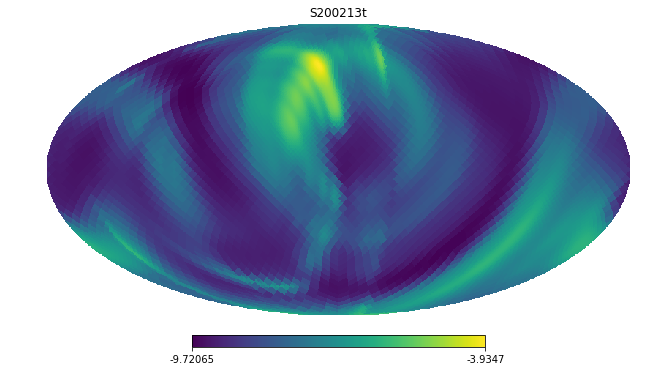

In [6]:
# filename = 'S190425z_bayestar.fits.gz'

skymap, header = hp.read_map(_filename, h=True, verbose=False)
hp.mollview(np.log10(skymap), title=_filename.split("_")[0],)

In [7]:
npix = len(skymap)
nside = hp.npix2nside(npix)


hp_index = np.arange(hp.nside2npix(nside))
mask = np.zeros(hp.nside2npix(nside))

for percentile in [0.9, 0.5, 0.1]:
    # Get index of element nearest to nth percentile 
    nth_element = np.argmin(np.abs(np.cumsum(skymap[np.argsort(skymap)[::-1]]) - percentile))
    # Add 1 to all elemets up to nth percentile 
    mask[np.argsort(skymap)[::-1][:nth_element]] += 1.0



0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


(17.391891891891895, 55.682145459789034)

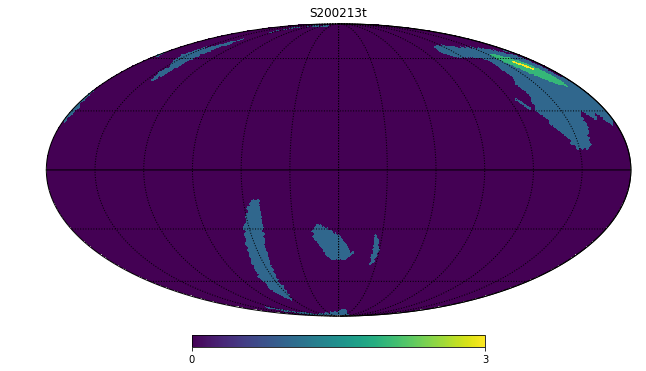

In [8]:
# rotate towards max value 
# theta, phi = hp.pix2ang(nside, np.argmax(skymap))
# hp.mollview(mask, rot=(np.rad2deg(phi), np.rad2deg(0.5 * np.pi - theta), 0))

# Reproduce GraceDB skymap with nth percentiles 
hp.mollview(mask, rot=(-180, 0, 0), flip="astro", title=_filename.split("_")[0])
hp.graticule()

# Ra/Dec of max
max_probability(skymap)

In [9]:
# image pixel coordinate grid
meshx, meshy = np.meshgrid(np.linspace(0,1023,1024),np.linspace(0,1023,1024))

# Image World coordinate system object 
image_wcs = WCS(_img)

# Image data
tmp_img = np.array(fits.open(_img)[0].data[0,0,:,:],dtype=np.float)

# convert image pixel coordinate grid to sky coordinates 
ra, dec, notused, nnotused = image_wcs.wcs_pix2world(meshx,meshy,1,1,1)

# Get skymap value interpolated at image pixel/WCS coordinate grid 
# this step is slow, lots of wasted calculations
output = hp.get_interp_val(mask, np.deg2rad(np.ravel(90-dec)), np.deg2rad(np.ravel(ra))).reshape(1024,1024)


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


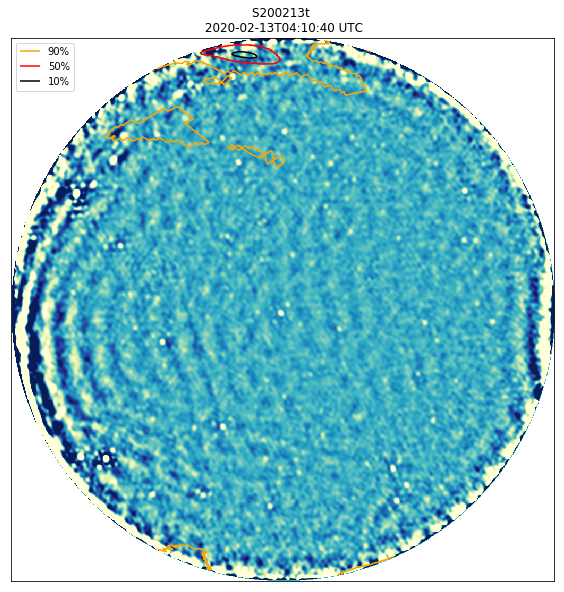

In [10]:

img_mean = np.nanmean(tmp_img)
img_std = np.nanstd(tmp_img)


plt.figure(figsize=(10,10))
plt.imshow(tmp_img, 
           vmin=img_mean-0.5*img_std, 
           vmax=img_mean+0.5*img_std, 
           origin="lower", cmap="YlGnBu_r")

CS =  plt.contour(output, linewidth=3, levels=[0.1,1.1,2.1], colors=["orange","red","black"])

plt.title("{} \n {} UTC".format(_filename.split("_")[0], _img.split("/")[3][:19]))
# plt.title("S190930t \n 2019-09-30 14:34:07 UTC")

plt.xticks([])
plt.yticks([])


try:
    labels = ['90%', '50%','10%']
    for i in range(len(labels)):
        CS.collections[i].set_label(labels[i])
except IndexError:
    print "Index Error: 10% banana not in image."
try:
    labels = ['90%', '50%']
    for i in range(len(labels)):
        CS.collections[i].set_label(labels[i])
except IndexError:
    print "Index Error: 50% banana not in image."
try:
    labels = ['90%']
    for i in range(len(labels)):
        CS.collections[i].set_label(labels[i])
except IndexError:
    print "Index Error: no bananas in image."  

        
plt.legend(loc='upper left')

plt.show()

In [ ]:


plt.figure(figsize=(10,10))
plt.imshow(tmp_img,vmin=-50, vmax=50, origin="lower", cmap="YlGnBu_r")

CS =  plt.contour(output, linewidth=3, levels=[0.1,1.1,2.1], colors=["orange","red","black"])


plt.title("S190425z \n 2019-04-25 09:20:00 UTC")
plt.xticks([])
plt.yticks([])

labels = ['90%', '50%','10%']
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])

plt.legend(loc='upper left')

plt.show()

<IPython.core.display.Javascript object>


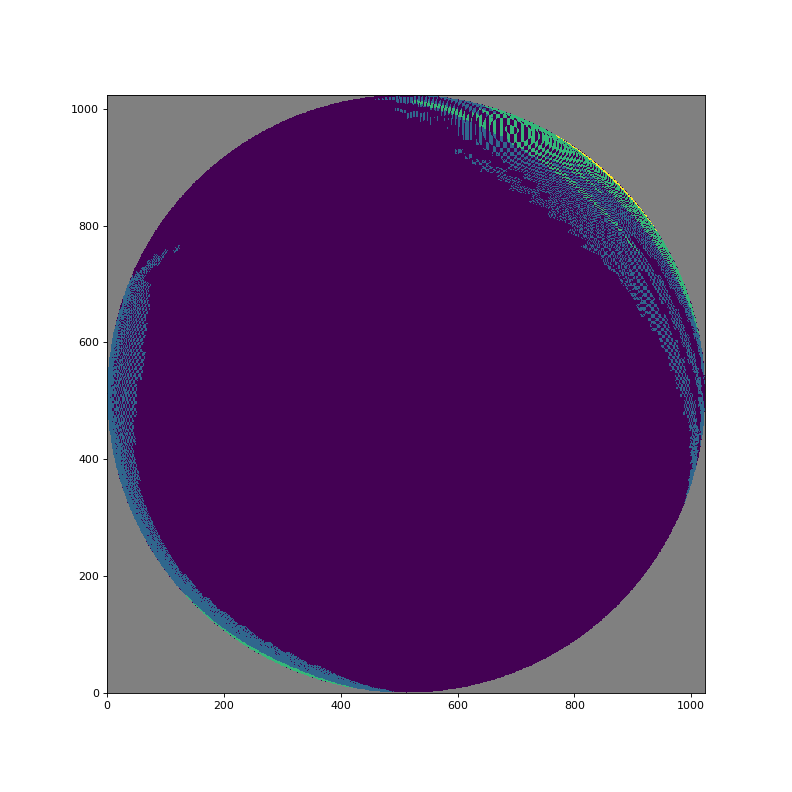

<IPython.core.display.Javascript object>


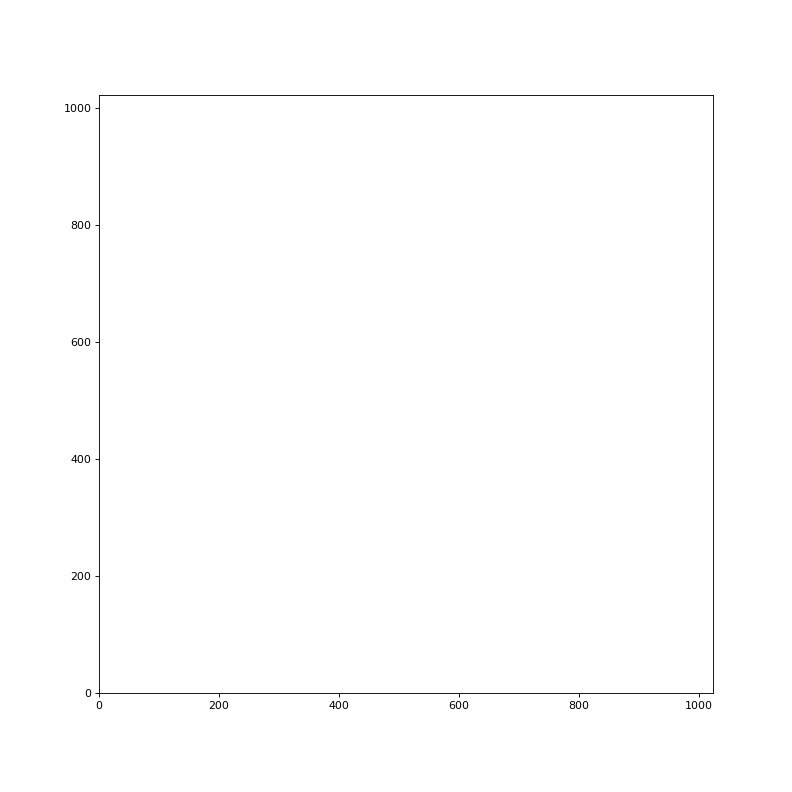

In [72]:
# img_contour_smooth = scipy.ndimage.zoom(img_contour, 30)
import scipy as sp
import scipy.ndimage
# Apply gaussian filter
sigma = [10, 10]
size = 2

img_contour_smooth = sp.ndimage.filters.uniform_filter(img_contour, size,cval=0, mode='constant')

plt.figure(figsize=(10,10))
plt.imshow(img_contour, origin="lower")
plt.figure(figsize=(10,10))
plt.contour(img_contour_smooth)

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


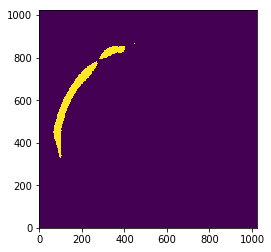

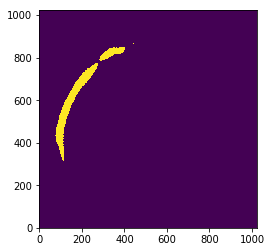

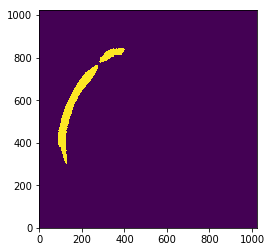

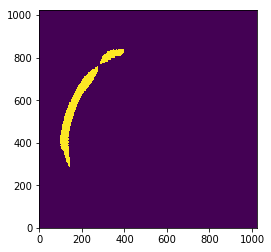

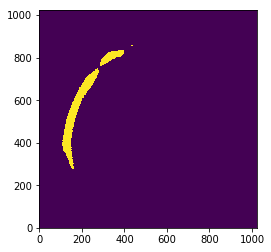

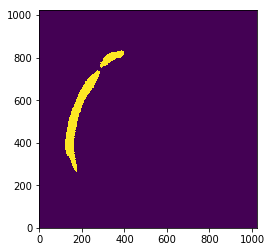

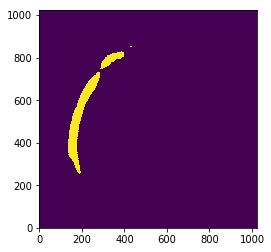

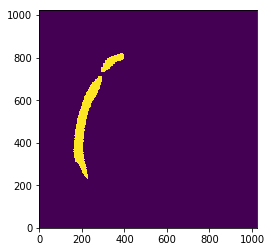

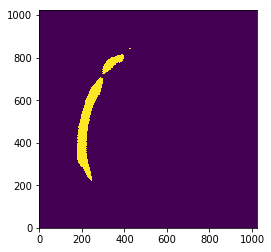

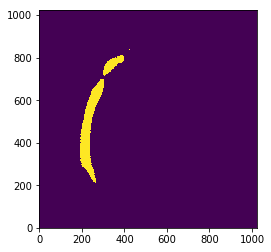

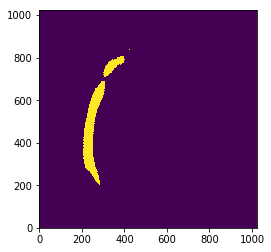

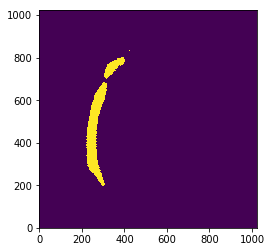

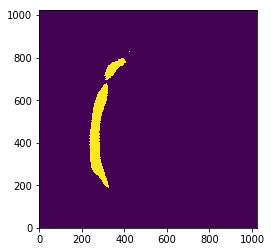

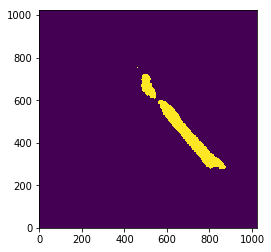

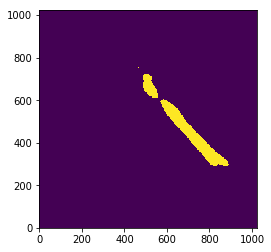

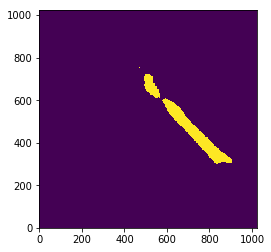

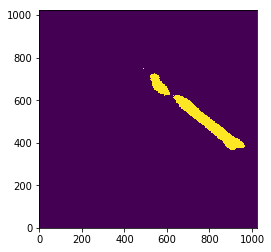

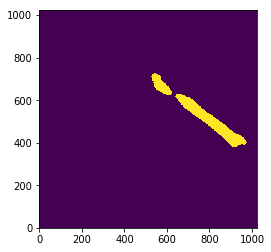

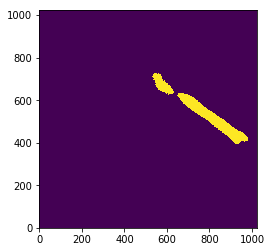

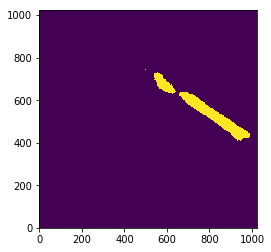

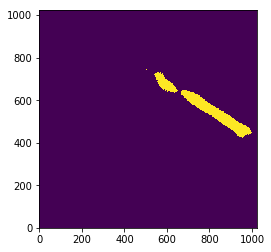

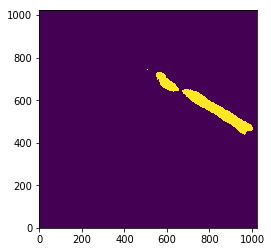

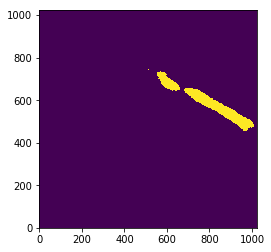

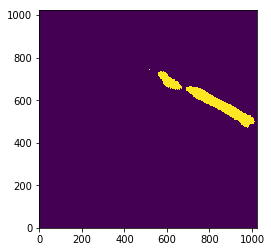

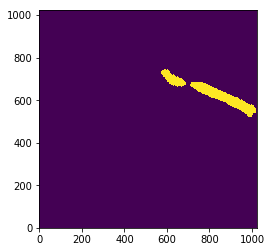

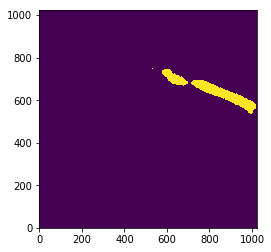

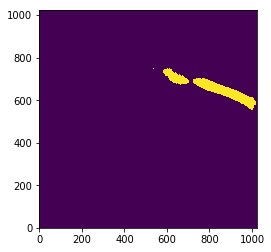

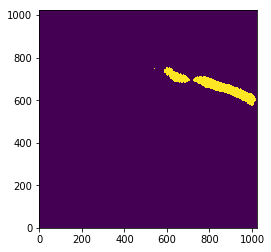

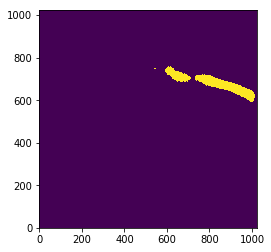

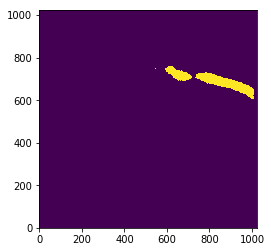

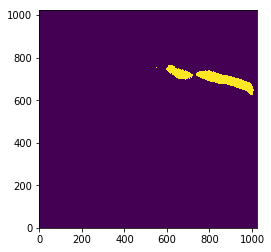

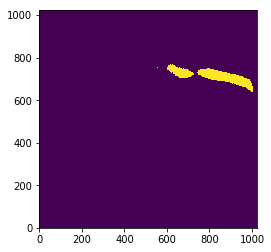

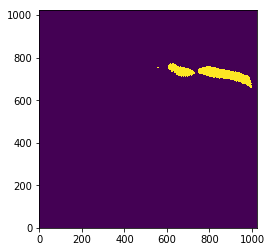

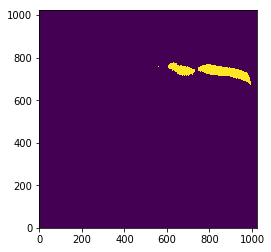

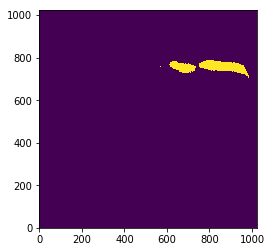

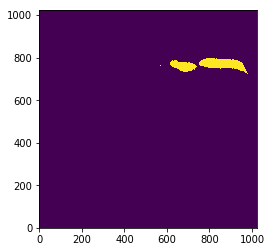

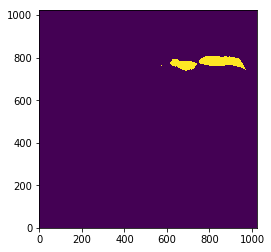

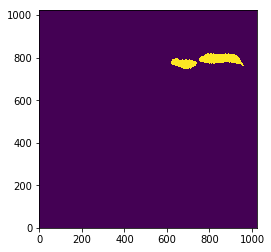

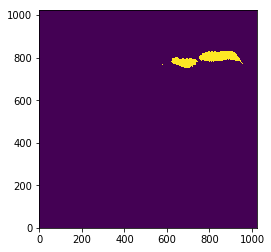

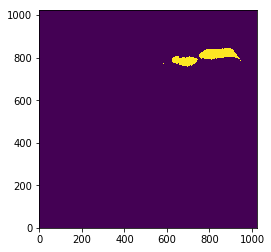

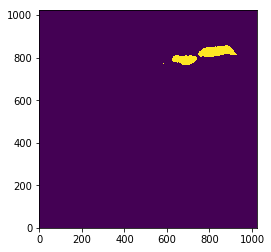

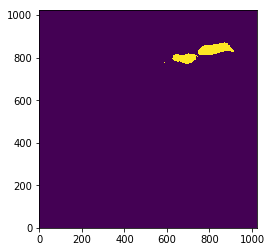

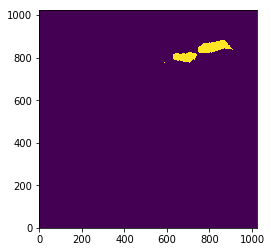

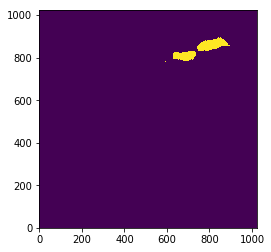

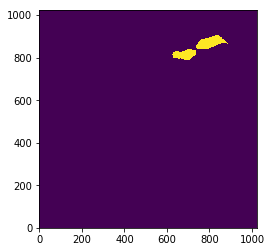

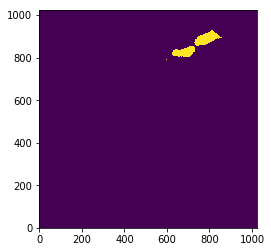

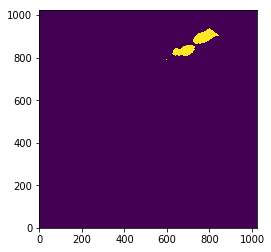

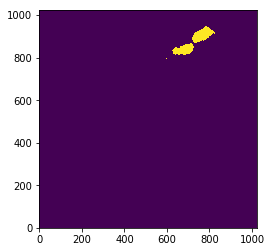

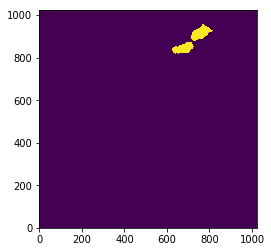

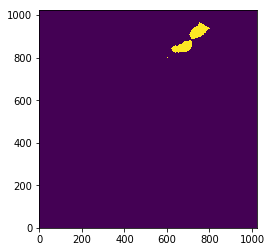

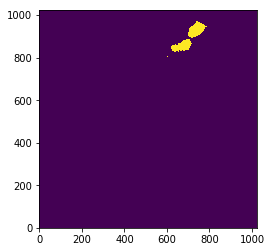

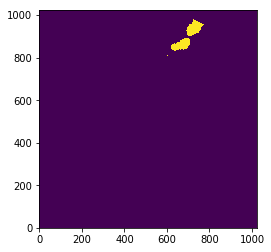

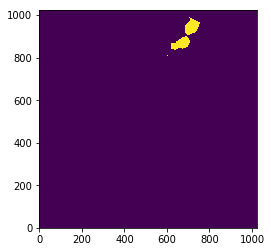

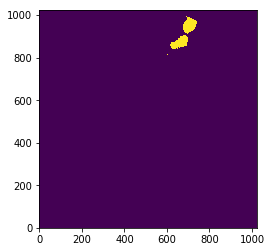

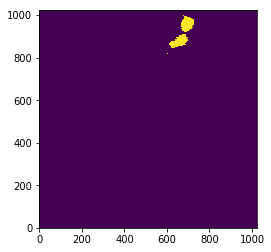

In [230]:

for _img in sorted(glob.glob("/data/20190408/2019-04-08T*:?0:27-S314-B8.fits")):

    plt.figure()
    meshx, meshy = np.meshgrid(np.linspace(0,1023,1024),np.linspace(0,1023,1024))
    image_wcs = WCS(_img)
    tmp_img = np.array(fits.open(_img)[0].data[0,0,:,:],dtype=np.float)

    ra,dec = hp.pixelfunc.pix2ang(nside, hp_index[mask != 0], lonlat=True)
    x, y, notused, nnotused = image_wcs.wcs_world2pix(ra,dec,1,1,1)

    img_contour = np.zeros([1023, 1023])

    img_contour[y[(np.abs(y - 512) < 512) & (np.abs(x - 512) < 512)].astype(int),
                x[(np.abs(y - 512) < 512) & (np.abs(x - 512) < 512)].astype(int)] = 1


    plt.imshow(img_contour, origin="lower")
    plt.show()

### Add all bananas


In [13]:
all_GW = [
    "S190408an",
    "S190930t",
    "S190930s",
"S190924h",
"S190923y",
"S190915ak",
"S190910h",
"S190910d",
"S190901ap",
"S190829u",
'S190828l',
'S190828j',
'S190816i',
'S190814bv',
'S190728q',
'S190727h',
'S190720a',
'S190718y',
'S190707q',
'S190706ai',
'S190701ah',
'S190630ag',
'S190602aq',
'S190521r',
'S190521g',
'S190519bj',
'S190517h',
'S190513bm',
'S190512at',
'S190510g',
'S190503bf',
'S190426c',
'S190425z',
'S190421ar',
'S190412m',
'S190408an'
]



In [14]:
for event in all_GW:
    
    download_skymap(event)
    
    skymap = hp.read_map(event+'_bayestar.fits.gz', h=False, verbose=False)
    print event, hp.get_nside(skymap)

# hp.mollview(np.log10(skymap))
    
    

curl --netrc https://gracedb.ligo.org/apiweb/superevents/S190408an/files/bayestar.fits.gz -o S190408an_bayestar.fits.gz
S190408an 1024
curl --netrc https://gracedb.ligo.org/apiweb/superevents/S190930t/files/bayestar.fits.gz -o S190930t_bayestar.fits.gz
S190930t 64
curl --netrc https://gracedb.ligo.org/apiweb/superevents/S190930s/files/bayestar.fits.gz -o S190930s_bayestar.fits.gz
S190930s 256
curl --netrc https://gracedb.ligo.org/apiweb/superevents/S190924h/files/bayestar.fits.gz -o S190924h_bayestar.fits.gz
S190924h 512
curl --netrc https://gracedb.ligo.org/apiweb/superevents/S190923y/files/bayestar.fits.gz -o S190923y_bayestar.fits.gz
S190923y 256
curl --netrc https://gracedb.ligo.org/apiweb/superevents/S190915ak/files/bayestar.fits.gz -o S190915ak_bayestar.fits.gz
S190915ak 512
curl --netrc https://gracedb.ligo.org/apiweb/superevents/S190910h/files/bayestar.fits.gz -o S190910h_bayestar.fits.gz
S190910h 64
curl --netrc https://gracedb.ligo.org/apiweb/superevents/S190910d/files/bayest

In [23]:
NPIX = hp.nside2npix(1024)
full_map = np.zeros(NPIX, dtype="float64")

for event in all_GW:
    
#     download_skymap(event)
    print event
    skymap = hp.read_map(event+'_bayestar.fits.gz', h=False, verbose=False)
    
    up_skymap = hp.ud_grade(skymap, 1024)
    
    full_map += up_skymap
    
    
#     print event, hp.get_nside(skymap)

S190408an
S190930t
S190930s
S190924h
S190923y
S190915ak
S190910h
S190910d
S190901ap
S190829u
S190828l
S190828j
S190816i
S190814bv
S190728q
S190727h
S190720a
S190718y
S190707q
S190706ai
S190701ah
S190630ag
S190602aq
S190521r
S190521g
S190519bj
S190517h
S190513bm
S190512at
S190510g
S190503bf
S190426c
S190425z
S190421ar
S190412m
S190408an


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


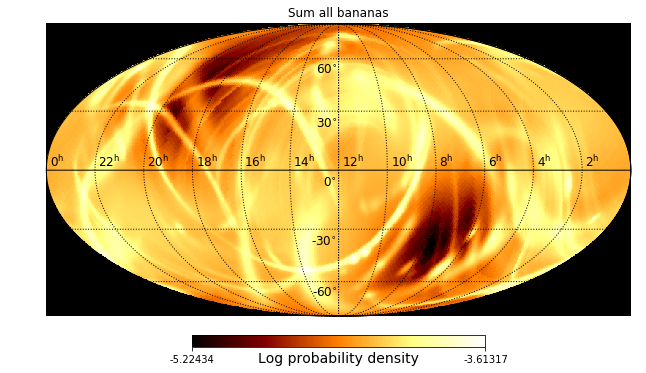

In [145]:
hp.mollview(np.log10(full_map), title="Sum all bananas", 
            coord="C",cmap="afmhot", notext=True,unit="Log probability density",rot=(180,0,0) )
hp.visufunc.graticule(dpar=30,dmer=30)

# hp.projtext(np.arange(0,12), np.zeros(12),np.arange(0,12), np.arange(0,12)  )

for i, j, k in zip(np.arange(0,360, 30)-2,np.zeros(12)+2,[str(label)+r"$^{\mathrm{h}}$" for label in np.arange(0,24,2)]):
    hp.projtext(i,j,k, coord="C", lonlat=True, fontsize=12)

for i, j, k in zip(180+np.ones(5),np.arange(-60,90,30)-3,[str(label)+r"$^{\circ}$" for label in np.arange(-60,90,30)]):
    hp.projtext(i,j,k, coord="C", lonlat=True, fontsize=12, ha="right", va="top")